# EDSR

In [ ]:
## for colab, make sure it uses python 3.8
!sudo update-alternatives --config python3
!sudo apt install python3-pip

In [1]:
# !pip install tensorflow-gpu==2.3.1 tensorflow-addons==0.11.2 ## replace to !pip install tensorflow for CPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 23 kB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
     |████████████████████████████████| 459 kB 62.0 MB/s 
     |████████████████████████████████| 2.9 MB 59.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      

In [2]:
# !git clone https://github.com/IritaSee/super-resolution-colab.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 408 (delta 0), reused 2 (delta 0), pack-reused 405
Receiving objects: 100% (408/408), 48.16 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [3]:
# %cd super-resolution

/content/super-resolution


In [1]:
!ls

 article.ipynb		       example_wdsr.ipynb
 data_engineering.ipynb        LICENSE
 data.py		       model
 demo			       new_dataset
 docs			       __pycache__
 environment.yml	       README.md
 example_edsr64.ipynb	       train.py
 example_edsr.ipynb	       utils.py
 example_srgan.ipynb	       weights
'example_wdsr depth 8.ipynb'   weights-edsr-16-x4.tar.gz


### Download Dataset (uncomment only if train!)

In [ ]:
# !pip install gdown

In [ ]:
# %cd new_dataset

In [ ]:
# ## uncommment only if train!

# import gdown
# url = "https://drive.google.com/drive/folders/1TF690mjUe-xPqVy6VjL6tNqHHBa5cYFd"
# gdown.download_folder(url, quiet=True, use_cookies=False)

# url = "https://drive.google.com/drive/folders/1p6Vh-XZjoCOvWYzgb3kaWuUGopi3hvfR"
# gdown.download_folder(url, quiet=True, use_cookies=False)

In [ ]:
# %cd ..

### Clear Area

In [2]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer

%matplotlib inline

2023-06-20 10:24:32.062203: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# Number of residual blocks
# depth = 16
# depth = 8
depth = 64

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [4]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights_edsr_depth64.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets


In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [6]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

2023-06-20 10:24:46.257610: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-06-20 10:24:46.292366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 10:24:46.292525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2023-06-20 10:24:46.292593: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2023-06-20 10:24:46.293901: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-06-20 10:24:46.324979: I tensorflo

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [7]:
!wget https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz

--2022-12-15 22:53:11--  https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5653330 (5,4M) [application/gzip]
Saving to: ‘weights-edsr-16-x4.tar.gz’

weights-edsr-16-x4. 100%[===================>]   5,39M   809KB/s    in 6,8s    

2022-12-15 22:53:20 (810 KB/s) - ‘weights-edsr-16-x4.tar.gz’ saved [5653330/5653330]



In [8]:
! tar -xf weights-edsr-16-x4.tar.gz

In [7]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

In [8]:
# Train EDSR model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
# Uncomment codes below for training!
trainer.train(train_ds,
              valid_ds.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/300000: loss = 7035.543, PSNR = 8.590852 (1833.62s)
2000/300000: loss = 116.588, PSNR = 13.689090 (1897.54s)
3000/300000: loss = 56.198, PSNR = 17.808235 (1913.59s)
4000/300000: loss = 35.015, PSNR = 20.493643 (1929.51s)
5000/300000: loss = 24.902, PSNR = 21.363092 (1937.25s)
6000/300000: loss = 18.732, PSNR = 23.510986 (1931.94s)
7000/300000: loss = 14.528, PSNR = 25.747929 (1943.55s)
8000/300000: loss = 11.487, PSNR = 27.293530 (1946.34s)
9000/300000: loss = 8.954, PSNR = 29.310598 (1949.81s)
10000/300000: loss = 7.217, PSNR = 30.417576 (1947.00s)
11000/300000: loss = 5.920, PSNR = 31.626484 (1948.71s)
12000/300000: loss = 5.017, PSNR = 32.105091 (1953.75s)
13000/300000: loss = 4.353, PSNR = 32.941833 (1950.90s)
14000/300000: loss = 3.974, PSNR = 33.391205 (1950.32s)
15000/300000: loss = 3.578, PSNR = 34.191963 (1957.20s)
16000/300000: loss = 3.346, PSNR = 35.088112 (1952.25s)
17000/300000: loss = 3.119, PSNR = 35.396706 (2178.91s)
18000/300000: loss = 2.935, PSNR = 36.318157 (1

In [9]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 205000.


In [10]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Validation (PSNR Score)

In [11]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

PSNR = 41.973591


## Demo

In [12]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [13]:
from model import resolve_single
from utils import load_image
from PIL import Image
import numpy as np

def convert_and_plot(lr_image_path):
    lr = np.array(Image.open(lr_image_path).convert('RGB'))
    
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

In [14]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

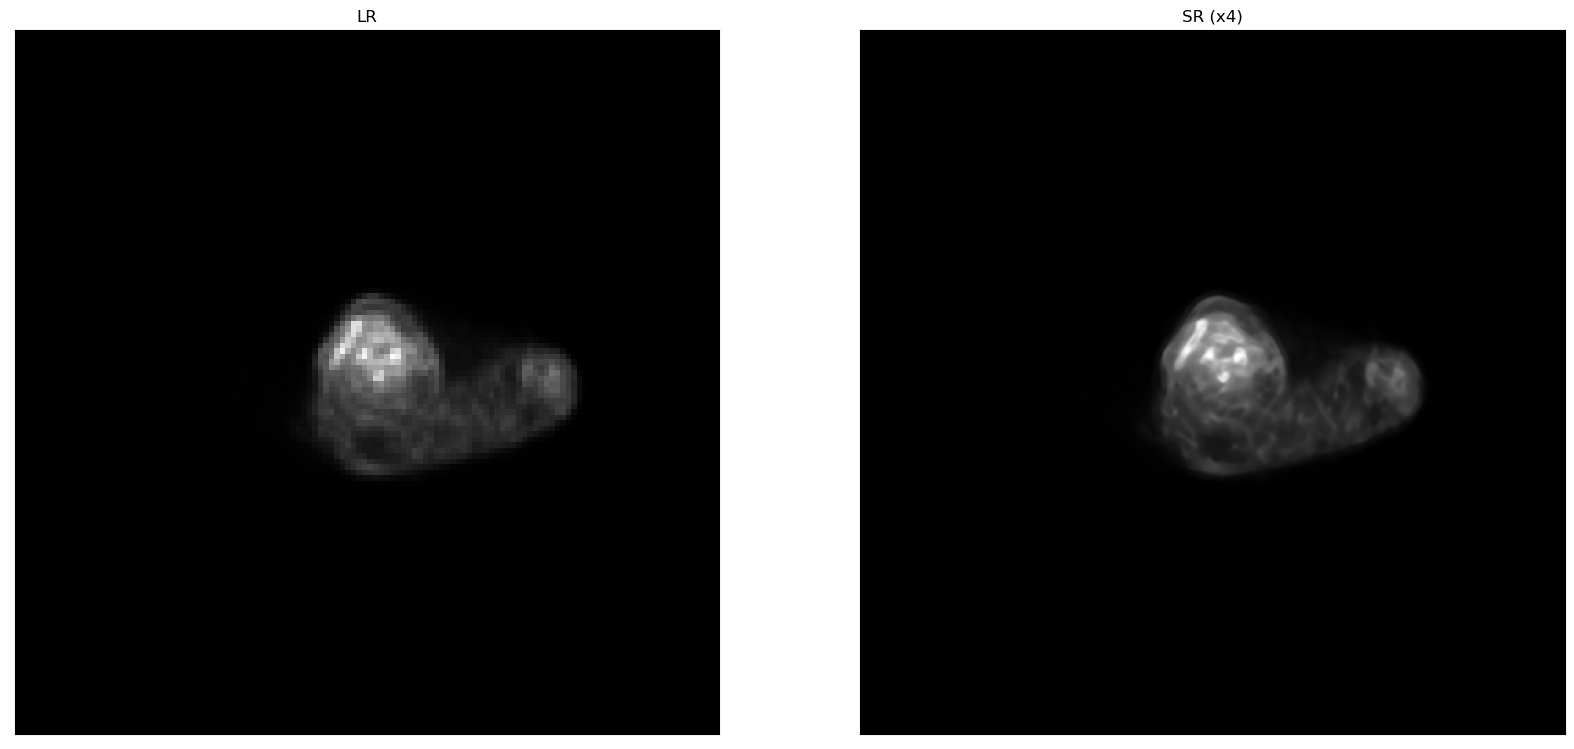

In [16]:
new_image = './new_dataset/PET-radiomics-challenges-kaggle/Training/1.3.6.1.4.1.14519.5.2.1.1707.8040.10059866353110167322451781.png'
convert_and_plot(new_image)

## SSIM : From Demo Image

In [17]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
new_image = './new_dataset/Y-90/downscaled/0150x4.png'

In [18]:
# load the two input images
lr = np.array(Image.open(new_image).convert('RGB'))
sr = resolve_single(model, lr)
imageA = cv2.imread('./new_dataset/Y-90/normal/0150.png')
imageB = np.array(sr)
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

In [20]:
# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.9768182702071848
